## unet 2d condition model

[unet](https://huggingface.co/docs/diffusers/en/api/models/unet2d-cond)

In [ ]:
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"  # Stable Diffusion v1.5
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet")

unet_sd = unet.state_dict()
# for key, value in unet_sd.items():
#     print(key, value.shape)
for name in unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim

    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    if cross_attention_dim is None:
        pass
    else:
        layer_name = name.split(".processor")[0]
        weights = {
            "to_k_ip.weight": unet_sd[layer_name + ".to_k.weight"],
            "to_v_ip.weight": unet_sd[layer_name + ".to_v.weight"],
        }
        print(True)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [3]:
! pip show torch torchvision

Name: torch
Version: 2.0.1+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: d:\my_sotfware\anaconda\envs\cameractrl\lib\site-packages
Requires: filelock, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, torchaudio, torchvision
---
Name: torchvision
Version: 0.15.2+cu118
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: d:\my_sotfware\anaconda\envs\cameractrl\lib\site-packages
Requires: numpy, pillow, requests, torch
Required-by: 


In [4]:
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

In [5]:
unet.attn_processors

{'down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a2577640>,
 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a2577cd0>,
 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a25e5420>,
 'down_blocks.0.attentions.1.transformer_blocks.0.attn2.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a25e5ab0>,
 'down_blocks.1.attentions.0.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a25e7700>,
 'down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a25e7d90>,
 'down_blocks.1.attentions.1.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x209a26254e0>,
 'down

In [ ]:
import os
import random
import argparse
from pathlib import Path
import json
import itertools
import time
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from transformers import CLIPImageProcessor
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection
from poseCtrl.models.pose_adaptor import VPmatrixEncoder, VPmatrixPoints
from poseCtrl.models.attention_processor import AttnProcessor, PoseAttnProcessor
from poseCtrl.data.dataset import MyDataset, load_base_points

def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str, 
        default='runwayml/stable-diffusion-v1-5',
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--pretrained_pose_path",
        type=str,
        default=None,
        help="Path to pretrained  posectrl model. If not specified weights are initialized randomly.",
    )
    # parser.add_argument(
    #     "--data_json_file",
    #     type=str,
    #     default=None,
    #     required=True,
    #     help="Training data",
    # )
    parser.add_argument(
        "--base_point_path",
        type=str,
        default=r'F:\Projects\diffusers\Project\PoseCtrl\dataSet\standardVertex.txt',
        help='Path to base model points'
    )
    parser.add_argument(
        "--data_root_path",
        type=str,
        default="F:\\Projects\\diffusers\\ProgramData\\pic",
        required=True,
        help="Training data root path",
    )
    parser.add_argument(
        "--image_encoder_path",
        type=str,
        default="laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
        required=True,
        help="Path to CLIP image encoder",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="sd-pose_ctrl",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images"
        ),
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Learning rate to use.",
    )
    parser.add_argument("--weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--num_train_epochs", type=int, default=100)
    parser.add_argument(
        "--train_batch_size", type=int, default=8, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument(
        "--save_steps",
        type=int,
        default=2000,
        help=(
            "Save a checkpoint of the training state every X updates"
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default="fp16",
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    
    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    return args

class posectrl(nn.Module):
    def __init__(self, unet, vpmatrix_points, atten_modules, ckpt_path=None):
        super().__init__()
        self.unet = unet
        self.vpmatrix_points = vpmatrix_points
        self.atten_modules = atten_modules

        if ckpt_path is not None:
            self.load_from_checkpoint(ckpt_path)

    def forward(self, noisy_latents, timesteps, encoder_hidden_states, V_matrix, P_matrix):
        point_tokens = self.vpmatrix_points(V_matrix, P_matrix)
        """ 修改:防止之后要加text """
        if encoder_hidden_states:
            encoder_hidden_states = torch.cat([encoder_hidden_states, point_tokens], dim=1)
        else:
            encoder_hidden_states=point_tokens
        # Predict the noise residual
        noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states).sample
        return noise_pred

    def load_from_checkpoint(self, ckpt_path: str):
        # Calculate original checksums
        orig_VPmatrix_sum = torch.sum(torch.stack([torch.sum(p) for p in self.vpmatrix_points.parameters()]))
        orig_atten_sum = torch.sum(torch.stack([torch.sum(p) for p in self.atten_modules.parameters()]))

        state_dict = torch.load(ckpt_path, map_location="cpu")

        # Load state dict for image_proj_model and adapter_modules
        self.vpmatrix_points.load_state_dict(state_dict["vpmatrix_points"], strict=True)
        self.atten_modules.load_state_dict(state_dict["atten_modules"], strict=True)

        # Calculate new checksums
        new_VPmatrix_sum = torch.sum(torch.stack([torch.sum(p) for p in self.vpmatrix_points.parameters()]))
        new_atten_sum = torch.sum(torch.stack([torch.sum(p) for p in self.atten_modules.parameters()]))

        # Verify if the weights have changed
        assert orig_VPmatrix_sum != new_VPmatrix_sum, "Weights of VPmatrixEncoder did not change!"
        assert orig_atten_sum != new_atten_sum, "Weights of atten_modules did not change!"

        print(f"Successfully loaded weights from checkpoint {ckpt_path}")

def main():
    args = parse_args()
    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )
    
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

    # Load scheduler, tokenizer and models.
    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
    tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="text_encoder")
    vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="unet")
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(args.image_encoder_path)

    # freeze parameters of models to save more memory
    unet.requires_grad_(False)
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    image_encoder.requires_grad_(False)
    
    #vp-matrix encoder
    raw_base_points=load_base_points(args.base_point_path)  
    vpmatrix_points_sd = VPmatrixEncoder(raw_base_points)

    # init pose modules
    attn_procs = {}
    unet_sd = unet.state_dict()
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim

        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]

        if cross_attention_dim is None:
            attn_procs[name] = AttnProcessor()
        else:
            layer_name = name.split(".processor")[0]
            weights = {
                "to_k_ip.weight": unet_sd[layer_name + ".to_k.weight"],
                "to_v_ip.weight": unet_sd[layer_name + ".to_v.weight"],
            }
            attn_procs[name] = PoseAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
            attn_procs[name].load_state_dict(weights)

    unet.set_attn_processor(attn_procs)

    atten_modules = torch.nn.ModuleList(unet.attn_processors.values())
    
    pose_ctrl = posectrl(unet, vpmatrix_points_sd, atten_modules, args.pretrained_pose_path)
    
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    #unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)
    image_encoder.to(accelerator.device, dtype=weight_dtype)
    
    # optimizer
    params_to_opt = itertools.chain(pose_ctrl.vpmatrix_points_sd.parameters(),  pose_ctrl.atten_modules.parameters())
    optimizer = torch.optim.AdamW(params_to_opt, lr=args.learning_rate, weight_decay=args.weight_decay)
    
    # dataloader
    train_dataset = MyDataset(args.data_root_path)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )
    
    # Prepare everything with our `accelerator`.
    pose_ctrl, optimizer, train_dataloader = accelerator.prepare(pose_ctrl, optimizer, train_dataloader)
    
    global_step = 0
    for epoch in range(0, args.num_train_epochs): #default is 100
        begin = time.perf_counter()
        for step, batch in enumerate(train_dataloader):
            load_data_time = time.perf_counter() - begin
            with accelerator.accumulate(pose_ctrl):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["image"].to(accelerator.device, dtype=weight_dtype)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                if "text_input_ids" in batch:
                    with torch.no_grad():
                        encoder_hidden_states = text_encoder(batch["text_input_ids"].to(accelerator.device))[0]
                else:
                    encoder_hidden_states=None
                
                noise_pred = pose_ctrl(noisy_latents, timesteps, encoder_hidden_states, batch['view_matrix'], batch['projection_matrix'])
        
                loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")
            
                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean().item()
                
                # Backpropagate
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()

                if accelerator.is_main_process:
                    print("Epoch {}, step {}, data_time: {}, time: {}, step_loss: {}".format(
                        epoch, step, load_data_time, time.perf_counter() - begin, avg_loss))
            
            global_step += 1
            
            if global_step % args.save_steps == 0:
                save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                accelerator.save_state(save_path)
            
            begin = time.perf_counter()

里面结构没改

应该有两个输入：图像和VP

VP： VPmatrixEncoder -> [77,77]

image: 
- :vae ->latent
- :resampler? 写一个 vit或者别的网络
- 那么训练参数会变成三个


# TODO
- 1. visEncoder.py
- 2. attention_processor.py： 加逻辑
- 3. posectrl.py: 加参数和逻辑
- 4. main.py：加参数
- 

In [ ]:
import torch
ckpt = "checkpoint-50000/pytorch_model.bin"
sd = torch.load(ckpt, map_location="cpu")
VPmatrixEncoder_sd = {}
atten_sd = {}
for k in sd:
    if k.startswith("unet"):
        pass
    elif k.startswith("VPmatrixEncoder"):
        VPmatrixEncoder_sd[k.replace("VPmatrixEncoder.", "")] = sd[k]
    elif k.startswith("atten_modules"):
        atten_sd[k.replace("atten_modules.", "")] = sd[k]

torch.save({"VPmatrixEncoder": VPmatrixEncoder_sd, "atten_modules": atten_sd}, "posectrl.bin")

1. 位置矩阵
2. 本地的坐标：可以和vp矩阵相乘，数学意义，M矩阵，
3. 多样性一点：图的特征，加上正面原图随便的特征。




4. 反向：训练什么

# TODO NEW Version 1

- inference
- VP矩阵不需要处理了
- BasePoints: [2000,4,4] @ [4,4] -> <77 768>（这个是text attention之后的结果，不知道图片他们都是怎么做的）可能可以换个大小，可学习的部分直接写出来更换就行。
- 好像流程就没啥问题了
- 每个要改的地方加上"修改",不然找不到忘记了.

# TODO NEW Version 2
   现在的逻辑是： vp矩阵[4,4], 顶点是[13860,4] (77x180), ->[13840,4] reshape [77,768]
-  要改：
   
~~- base_load~~

~~- pose_adaptor~~

   ~~- posectrl traning~~ 
   - 和 posectrl inference   
 
   ~~- attention_pocessor~~ 和之前没区别

   ~~- train main~~

   ~~- 跑通~~

# TODO NEW Version 3
加了个参考图， 这个图attention 加上

~~- dataset 1024 resize~~, 可以不加数量限制

~~- image sampler~~

~~- posectrl train main~~

~~- attention~~

- posectrl.py
- inference
- validaton
- train 得到weights
- inference

# Questions
~~1. 需不要把好坏prompt设置成~~
 
python 
```
if prompt is None:
    prompt = "best quality, high quality"
if negative_prompt is None:
    negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
```

不用应该

- 2. point-e好像是生成3d底模的东西,不知道有没有用

In [5]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# 1. 选择 CLIP 预训练模型
model_name = "openai/clip-vit-base-patch16"  # 也可以换成 "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# 2. 读取并预处理图片
image_path = r"F:\Projects\diffusers\ProgramData\sample_new\NPC_Avatar_Girl_Sword_Ayaka\feature.png"  # 替换成你的图片路径
image = Image.open(image_path)

inputs = processor(images=image, return_tensors="pt")  # 预处理
image_tensor = inputs["pixel_values"]  # 获取输入张量，形状 (1, 3, 224, 224)

# 3. 获取所有 patch 的特征
with torch.no_grad():
    vision_outputs = model.vision_model(image_tensor)  # 获取所有 Transformer 层的输出
    patch_features = vision_outputs.last_hidden_state  # 形状: (B, X+1, 768)

# 4. 移除 CLS token（第一个 token）
patch_features = patch_features[:, 1:, :]  # (B, X, 768)

print("Patch feature shape:", patch_features.shape)  # 目标形状: (B, X, 768)


Patch feature shape: torch.Size([1, 196, 768])


In [8]:
!pip install safetensors

In [ ]:
import torch
import torch
from pathlib import Path
def change_checkpoint(checkpoint_path, new_checkpoint_path):
    sd = torch.load(checkpoint_path, map_location="cpu")
    vpmatrix_points_sd = {}
    atten_sd = {}
    proj_sd={}
    for k in sd:
        if k.startswith("unet"):
            pass
        elif k.startswith("vpmatrix_points"):
            vpmatrix_points_sd[k.replace("vpmatrix_points.", "")] = sd[k]
        elif k.startswith("atten_modules"):
            atten_sd[k.replace("atten_modules.", "")] = sd[k]
        elif k.startswith("image_proj_model"):
            proj_sd[k.replace("image_proj_model.", "")] = sd[k]
    new_checkpoint_path = Path(new_checkpoint_path, "posectrl.bin")
    print(vpmatrix_points_sd)
    print(atten_sd)
    print(proj_sd)
    for name in sd['state'].keys():
        print(name)
    torch.save({"vpmatrix_points": vpmatrix_points_sd, "atten_modules": atten_sd, "image_proj_model": proj_sd}, new_checkpoint_path)
    print(f"Saved new checkpoint to {new_checkpoint_path}")

ckpt = r"F:\Projects\diffusers\Project\PoseCtrl\sd-pose_ctrl\model.safetensors"

change_checkpoint(ckpt, r"F:\Projects\diffusers\Project\PoseCtrl\sd-pose_ctrl\transfer")


UnpicklingError: invalid load key, '\x18'.

In [ ]:
import torch
from safetensors.torch import load_file
from pathlib import Path

def change_checkpoint(checkpoint_path, new_checkpoint_path):
    # 使用 safetensors 加载文件
    sd = load_file(checkpoint_path)
    
    vpmatrix_points_sd = {}
    atten_sd = {}
    proj_sd = {}
    
    # 遍历模型权重并分类
    i, j = 1 , 1
    for k in sd:
        # print(k)
        if k.startswith("unet"):
            pass
        elif k.startswith("vpmatrix_points"):
            vpmatrix_points_sd[k.replace("vpmatrix_points.", "")] = sd[k]
        elif k.startswith("atten_modules"):
            atten_sd[k.replace("atten_modules.", "")] = sd[k]
        elif k.startswith("image_proj_model"):
            proj_sd[k.replace("image_proj_model.", "")] = sd[k]

    # 指定新的文件路径
    new_checkpoint_path = Path(new_checkpoint_path, "posectrl2.bin")
    
    print(atten_sd)
    
    # 保存为新的二进制 checkpoint 文件
    torch.save({
        "vpmatrix_points": vpmatrix_points_sd,
        "atten_modules": atten_sd,
        "image_proj_model": proj_sd
    }, new_checkpoint_path)
    
    print(f"Saved new checkpoint to {new_checkpoint_path}")

# 使用 safetensors 文件路径
ckpt = r"F:\Projects\diffusers\Project\PoseCtrl\sd-pose_ctrl\model.safetensors"

# 调用转换函数
change_checkpoint(ckpt, r"F:\Projects\diffusers\Project\PoseCtrl\sd-pose_ctrl\transfer")


unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor.to_k_ip.weight torch.Size([320, 768]) 1
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor.to_v_ip.weight torch.Size([320, 768]) 1
unet.down_blocks.0.attentions.1.transformer_blocks.0.attn2.processor.to_k_ip.weight torch.Size([320, 768]) 3
unet.down_blocks.0.attentions.1.transformer_blocks.0.attn2.processor.to_v_ip.weight torch.Size([320, 768]) 3
unet.down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor.to_k_ip.weight torch.Size([640, 768]) 5
unet.down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor.to_v_ip.weight torch.Size([640, 768]) 5
unet.down_blocks.1.attentions.1.transformer_blocks.0.attn2.processor.to_k_ip.weight torch.Size([640, 768]) 7
unet.down_blocks.1.attentions.1.transformer_blocks.0.attn2.processor.to_v_ip.weight torch.Size([640, 768]) 7
unet.down_blocks.2.attentions.0.transformer_blocks.0.attn2.processor.to_k_ip.weight torch.Size([1280, 768]) 9
unet.down_blocks.2

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
d:\MY_SOTFWARE\anaconda\envs\cameractrl\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To 

torch.Size([13860, 4])


d:\MY_SOTFWARE\anaconda\envs\cameractrl\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion_img2img.py:663: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/30 [00:00<?, ?it/s]

d:\MY_SOTFWARE\anaconda\envs\cameractrl\lib\site-packages\diffusers\image_processor.py:97: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


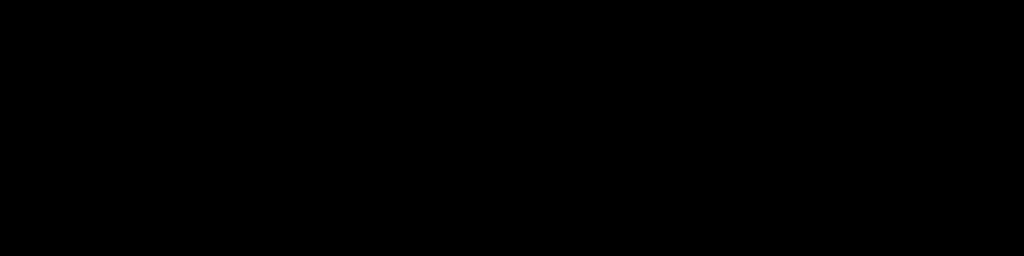

In [1]:
import torch
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image
import sys
import os
sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl')
sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl\poseCtrl')
from poseCtrl.models.pose_adaptor import VPmatrixPoints, ImageProjModel
from poseCtrl.models.attention_processor import AttnProcessor, PoseAttnProcessor
from poseCtrl.data.dataset import CustomDataset, load_base_points
from poseCtrl.models.posectrl import PoseCtrl



base_point_path=r'F:\Projects\diffusers\Project\PoseCtrl\dataSet\standardVertex.txt'
raw_base_points=load_base_points(base_point_path)  

base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_ckpt = r"F:\Projects\diffusers\Project\sd-pose_ctrl\posectrl.bin"
device = "cuda"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# load SD pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

path = r"F:\\Projects\\diffusers\\ProgramData\\sample_new"
dataset = CustomDataset(path)
data = dataset[0]
from torchvision import transforms

transform = transforms.Resize((256, 256))

image = data['image']
image = transform(image) 
g_image = data['feature']
g_image = transform(g_image) 

vmatrix = data['view_matrix'].to(torch.float16).unsqueeze(0).to(device)
pmatrix = data['projection_matrix'].to(torch.float16).unsqueeze(0).to(device)

pose_model = PoseCtrl(pipe, image_encoder_path, ip_ckpt, raw_base_points, device)
images = pose_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6, V_matrix=vmatrix,P_matrix=pmatrix )
grid = image_grid(images, 1, 4)
grid





In [39]:
pose_model = PoseCtrl(pipe, image_encoder_path, ip_ckpt, raw_base_points, device)
images = pose_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6, V_matrix=vmatrix,P_matrix=pmatrix )
grid = image_grid(images, 1, 4)
grid

Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_model.encoder.layers.23.layer_norm2.weight', 'text_model.encoder.layers.13.layer_norm1.bias', 'text_model.encoder.layers.12.self_attn.q_proj.weight', 'text_model.encoder.layers.17.self_attn.out_proj.weight', 'text_model.encoder.layers.7.self_attn.k_proj.weight', 'text_model.encoder.layers.6.self_attn.v_proj.weight', 'text_model.encoder.layers.8.self_attn.q_proj.bias', 'text_model.encoder.layers.23.self_attn.out_proj.bias', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.16.layer_norm1.bias', 'text_model.encoder.layers.17.self_attn.q_proj.bias', 'text_model.encoder.layers.3.mlp.fc2.bias', 'text_model.encoder.layers.3.self_attn.v_proj.weight', 'text_model.encoder.layers.12.self_attn.out_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model

torch.Size([13860, 4])
{'31.to_k_ip.weight': tensor([[-0.0065,  0.0132, -0.0028,  ..., -0.0033,  0.0308,  0.0227],
        [ 0.0080, -0.0480,  0.0373,  ..., -0.0060,  0.0455,  0.0155],
        [-0.0357,  0.0118, -0.0137,  ...,  0.0052, -0.0451, -0.0260],
        ...,
        [-0.0271,  0.0085,  0.0243,  ..., -0.0136, -0.0057, -0.0120],
        [ 0.0143,  0.0092, -0.0138,  ...,  0.0592,  0.0064, -0.0519],
        [ 0.0661,  0.0127,  0.0268,  ..., -0.0758, -0.0880,  0.0991]]), '31.to_v_ip.weight': tensor([[ 0.0035,  0.0043,  0.0010,  ..., -0.0058, -0.0055,  0.0105],
        [ 0.0067,  0.0251, -0.0053,  ...,  0.0087,  0.0110,  0.0010],
        [-0.0129, -0.0031,  0.0133,  ...,  0.0007, -0.0104, -0.0065],
        ...,
        [ 0.0086, -0.0129,  0.0013,  ...,  0.0094,  0.0074,  0.0191],
        [-0.0027, -0.0009,  0.0189,  ..., -0.0010,  0.0096,  0.0106],
        [ 0.0004,  0.0368,  0.0139,  ..., -0.0083, -0.0237,  0.0085]]), '29.to_k_ip.weight': tensor([[-0.0142, -0.0629, -0.0299,  ..., -

RuntimeError: Error(s) in loading state_dict for ModuleList:
	Missing key(s) in state_dict: "1.to_k_ip.weight", "1.to_v_ip.weight", "3.to_k_ip.weight", "3.to_v_ip.weight", "5.to_k_ip.weight", "5.to_v_ip.weight", "7.to_k_ip.weight", "7.to_v_ip.weight", "9.to_k_ip.weight", "9.to_v_ip.weight", "11.to_k_ip.weight", "11.to_v_ip.weight", "13.to_k_ip.weight", "13.to_v_ip.weight". 
	size mismatch for 19.to_k_ip.weight: copying a param with shape torch.Size([1280, 768]) from checkpoint, the shape in current model is torch.Size([640, 768]).
	size mismatch for 19.to_v_ip.weight: copying a param with shape torch.Size([1280, 768]) from checkpoint, the shape in current model is torch.Size([640, 768]).
	size mismatch for 25.to_k_ip.weight: copying a param with shape torch.Size([640, 768]) from checkpoint, the shape in current model is torch.Size([320, 768]).
	size mismatch for 25.to_v_ip.weight: copying a param with shape torch.Size([640, 768]) from checkpoint, the shape in current model is torch.Size([320, 768]).
	size mismatch for 31.to_k_ip.weight: copying a param with shape torch.Size([320, 768]) from checkpoint, the shape in current model is torch.Size([1280, 768]).
	size mismatch for 31.to_v_ip.weight: copying a param with shape torch.Size([320, 768]) from checkpoint, the shape in current model is torch.Size([1280, 768]).

In [ ]:
import os
import torch
from safetensors.torch import load_file
import pickle

def convert_sd_weights_to_bin(folder_path, output_bin_path):
    """
    将 Stable Diffusion 文件夹中的多个权重文件（safetensors, bin, pkl, pt）合并并保存为 .bin 格式。

    :param folder_path: 包含权重文件的文件夹路径
    :param output_bin_path: 输出的 .bin 文件路径
    """
    merged_state_dict = {}  # 存储所有权重的字典

    # 遍历文件夹，找到所有权重文件
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        if filename.endswith('.safetensors'):
            print(f"Loading {file_path} (safetensors)...")
            state_dict = load_file(file_path, device="cpu")
        elif filename.endswith('.bin'):
            print(f"Loading {file_path} (bin)...")
            state_dict = torch.load(file_path, map_location="cpu")
        elif filename.endswith('.pkl'):
            print(f"Loading {file_path} (pkl)...")
            with open(file_path, "rb") as f:
                state_dict = pickle.load(f)
        elif filename.endswith('.pt'):
            print(f"Loading {file_path} (pt)...")
            state_dict = torch.load(file_path, map_location="cpu")
        else:
            print(f"Skipping {file_path}, unsupported format.")
            continue

        # 合并权重（如果存在相同的 key，则不会覆盖）
        for key, value in state_dict.items():
            if key not in merged_state_dict:
                merged_state_dict[key] = value

    # 保存到 .bin 文件
    torch.save(merged_state_dict, output_bin_path)
    print(f"Saved merged weights to {output_bin_path}")

# 示例用法
folder_path = r"/content/sd-pose_ctrl/checkpoint-20"  # 替换为你的文件夹路径
output_bin_path = r"/content/sd-pose_ctrl/checkpoint-20/stable_diffusion.bin"  # 目标 bin 文件路径

convert_sd_weights_to_bin(folder_path, output_bin_path)


Removed shared tensor {'atten_modules.27.to_v_ip.weight', 'atten_modules.19.to_v_ip.weight', 'atten_modules.1.to_k_ip.weight', 'atten_modules.29.to_k_ip.weight', 'atten_modules.5.to_k_ip.weight', 'atten_modules.23.to_k_ip.weight', 'atten_modules.11.to_v_ip.weight', 'atten_modules.3.to_k_ip.weight', 'atten_modules.9.to_v_ip.weight', 'atten_modules.9.to_k_ip.weight', 'atten_modules.13.to_v_ip.weight', 'atten_modules.27.to_k_ip.weight', 'atten_modules.3.to_v_ip.weight', 'atten_modules.15.to_v_ip.weight', 'atten_modules.25.to_k_ip.weight', 'atten_modules.31.to_k_ip.weight', 'atten_modules.25.to_v_ip.weight', 'atten_modules.7.to_k_ip.weight', 'atten_modules.15.to_k_ip.weight', 'atten_modules.21.to_v_ip.weight', 'atten_modules.19.to_k_ip.weight', 'atten_modules.11.to_k_ip.weight', 'atten_modules.7.to_v_ip.weight', 'atten_modules.13.to_k_ip.weight', 'atten_modules.17.to_k_ip.weight', 'atten_modules.1.to_v_ip.weight', 'atten_modules.29.to_v_ip.weight', 'atten_modules.17.to_v_ip.weight', 'atten_modules.5.to_v_ip.weight', 'atten_modules.21.to_k_ip.weight', 'atten_modules.31.to_v_ip.weight', 'atten_modules.23.to_v_ip.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading

python train_colab.py --save_steps 2
2025-02-17 10:33:25.135034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 10:33:25.153738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1739788405.175769    6816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739788405.182549    6816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 10:33:25.204841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Traceback (most recent call last):
  File "/content/train_colab.py", line 346, in <module>
    main()  
    ^^^^^^
  File "/content/train_colab.py", line 286, in main
    pose_ctrl, optimizer, train_dataloader = accelerator.prepare(pose_ctrl, atten_modules, optimizer, train_dataloader)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
Removed shared tensor {'atten_modules.27.to_v_ip.weight', 'atten_modules.19.to_v_ip.weight', 'atten_modules.1.to_k_ip.weight', 'atten_modules.29.to_k_ip.weight', 'atten_modules.5.to_k_ip.weight', 'atten_modules.23.to_k_ip.weight', 'atten_modules.11.to_v_ip.weight', 'atten_modules.3.to_k_ip.weight', 'atten_modules.9.to_v_ip.weight', 'atten_modules.9.to_k_ip.weight', 'atten_modules.13.to_v_ip.weight', 'atten_modules.27.to_k_ip.weight', 'atten_modules.3.to_v_ip.weight', 'atten_modules.15.to_v_ip.weight', 'atten_modules.25.to_k_ip.weight', 'atten_modules.31.to_k_ip.weight', 'atten_modules.25.to_v_ip.weight', 'atten_modules.7.to_k_ip.weight', 'atten_modules.15.to_k_ip.weight', 'atten_modules.21.to_v_ip.weight', 'atten_modules.19.to_k_ip.weight', 'atten_modules.11.to_k_ip.weight', 'atten_modules.7.to_v_ip.weight', 'atten_modules.13.to_k_ip.weight', 'atten_modules.17.to_k_ip.weight', 'atten_modules.1.to_v_ip.weight', 'atten_modules.29.to_v_ip.weight', 'atten_modules.17.to_v_ip.weight', 'atten_modules.5.to_v_ip.weight', 'atten_modules.21.to_k_ip.weight', 'atten_modules.31.to_v_ip.weight', 'atten_modules.23.to_v_ip.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading